# Uniform Cylinder Analysis

In this notebook, we will go through the steps of comparing the measured and simulated data obtained from the uniform cylinder. 

In the sinogram-space, we will calculate the 

- Total number of true coincidences
- Random fraction
- Sensitivity
- Scatter fraction

In the image-space, we will calculate the

- Image integral uniformity within slice
- Image integral axial uniformity

In [1]:
from analysis_fns import plot_sino, calc_sens, plot_sens, perform_SF_cal, plot_img, plot_uniformity
import numpy as np
import os

%matplotlib notebook

Load the measured sinogram
- estimate the total number of true detections
- estimate the random fraction
- plot the sinogram using interactive plotting

Random fraction: 0.19
Total trues: 366662073


<IPython.core.display.Javascript object>


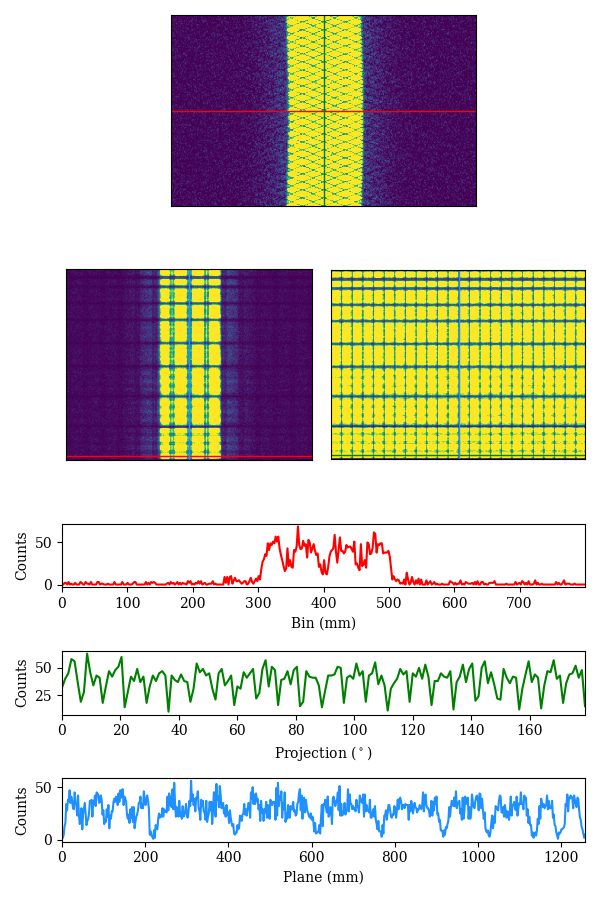

In [2]:
# Load the data
scan_sinogram_fn = '../patients/uniform_meas/sino.s'
scan_sino = np.fromfile(scan_sinogram_fn, dtype=np.int16)
# Order: planes, projection/view, bin/element
scan_sino = scan_sino.reshape((14,621,168,400))

# Calculate the random fraction
print('Random fraction: %0.2f' % (np.sum(scan_sino[13])/np.sum(scan_sino[:13])))

# Add all of the prompt bins and subtract the delays
scan_sino = np.sum(scan_sino[:13], axis=0) - scan_sino[13]
# Don't allow values less than zero
scan_sino = np.clip(scan_sino, 0, np.max(scan_sino))
print('Total trues: %i' % (np.sum(scan_sino)))

plot_sino(scan_sino, vmin=np.min(scan_sino), vmax=30, 
          slice_indx=[14,84,200],
              spacing=np.array([2.027, 1.07143, 2.005]),
          draw_lines=True)

Load the simulated sinogram
- calculate the total number of true detections
- calculate the random fraction
- plot the sinogram using interactive plotting

Random fraction: 0.25
Total trues: 347159369


<IPython.core.display.Javascript object>


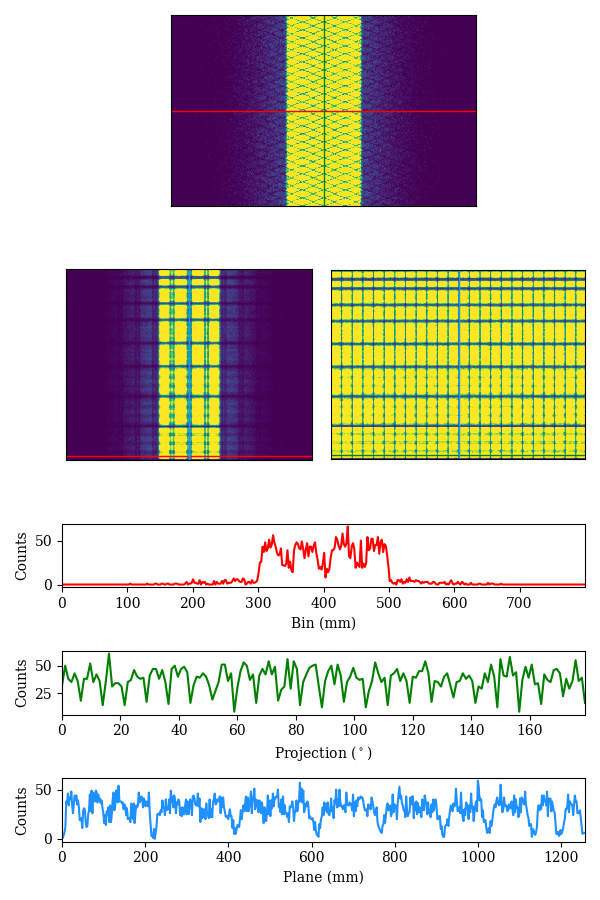

In [3]:
# Load the true detections
simu_sinogram_fn = '../patients/uniform_simu/sino.s'
simu_sino = np.fromfile(simu_sinogram_fn, dtype=np.int16)
# Load the delayed detections
simu_delay_sinogram_fn = '../patients/uniform_simu/sino_delay.s'
simu_delay_sino = np.fromfile(simu_delay_sinogram_fn, dtype=np.int16)

# Calculate the random fraction
print('Random fraction: %0.2f' % (np.sum(simu_delay_sino)/(np.sum(simu_delay_sino) + np.sum(simu_sino))))
print('Total trues: %i' % (np.sum(simu_sino)))

# Order: planes, projection/view, bin/element
simu_sino = simu_sino.reshape((621,168,400))

plot_sino(simu_sino, vmin=np.min(simu_sino), vmax=30, 
          slice_indx=[14,84,200],
              spacing=np.array([2.027, 1.07143, 2.005]),
          draw_lines=True)

To calculate the sensitivity, we can sum all of the 9 segments within the sinogram (by centering each segment), then compare (plane-by-plane) the measured activity within a given plane to the actual activity within that plane:

\begin{equation}
S = \frac{\mathcal{A_{meas}}}{\mathcal{A_{plane}}}
\label{N_decay}
\end{equation}

the global activity uses the same ratio, but taking into account all of the planes in question

The global sensitivity in the central 60% is 10.04 cps/kBq
The global sensitivity in the central 60% is 9.48 cps/kBq


<IPython.core.display.Javascript object>


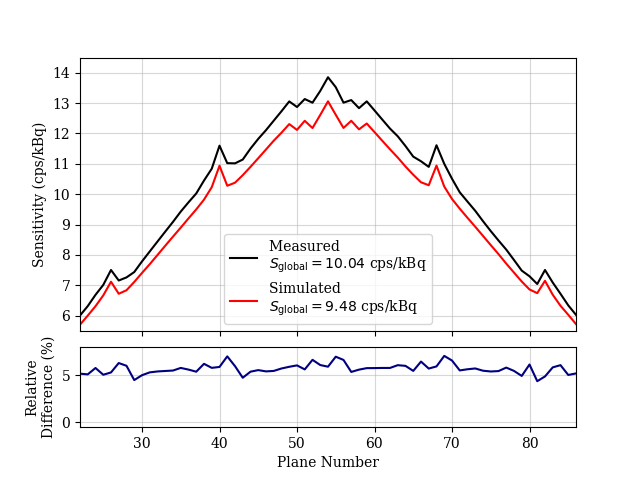

In [4]:
scan_sino_sens, scan_glob_sens = calc_sens(scan_sino, act_conc=12350, t=600)
simu_sino_sens, simu_glob_sens = calc_sens(simu_sino, act_conc=12350, t=600)

plot_sens(scan_sino_sens, scan_glob_sens, simu_sino_sens, simu_glob_sens, savename=None)

To estimate the scatter fraction, we will assume that the total number of counts in a single plane can be represented by

\begin{equation}
T(r) = \mathrm{PSF}(r) \circledast (P(r,D,p) + S(r))
\label{T}
\end{equation}

where the primary counts, $P(r,D,p)$, is given by the equation of a circle with the appropriate attenuation correction:

\begin{equation}
P(r,D,p)=
\begin{cases}
  2p\sqrt{\frac{1}{4}D^2 - r^2}e^{-2\mu \sqrt{\frac{1}{4}D^2 - r^2}}, & |r| \le \frac{D}{2}
\\
  0, & |r|>\frac{D}{2}
\end{cases}
\label{P}
\end{equation}

In this formula, $p$ is a scaling factor for the total number of detected primary photons that depends on both activity in the phantom and sensitivity of the scanner.

The scatter counts, $S(r)$, is modeled by a piecewise linear function between the coordinates ($r_1 , y_1$) and ($r_2 , y_2$), ($r_2 , y_2$) and ($r_3 , y_3$), and so on.

The point spread function, $PSF(r)$, is a 1D function describing the resolution of the projection data. Furthermore, $PSF(r)$ removes discontinuities at the control points for $S(r)$.

Therefore, $T(r)$ has $p$ and the five base points $y_1$, ..., $y_5$ as free parameters and can be fit to the measured profile. In order to mitigate the effect of the gaps in the sinogram, the average profile along the projection axis was used for the fitting.

Once the parameters are determined, the scatter fraction can be calculated from

\begin{equation}
SF = \frac{\int_{-\frac{3D}{10}}^{\frac{3D}{10}}S(r)dr}{\int_{-\frac{3D}{10}}^{\frac{3D}{10}}T(r)dr}
\label{SF}
\end{equation}

Since we the model assumes random detections to be present, we will reload the sinograms and include the random counts.

In [5]:
scan_sinogram_fn = '../patients/uniform_meas/sino.s'
scan_sino = np.fromfile(scan_sinogram_fn, dtype=np.int16)
# Order: planes, projection/view, bin/element
scan_sino = scan_sino.reshape((14,621,168,400))
# Sum all of the prompt detections
scan_sino = np.sum(scan_sino[:13], axis=0)

In [6]:
# True detections
simu_sinogram_fn = '../patients/uniform_simu/sino.s'
simu_sino = np.fromfile(simu_sinogram_fn, dtype=np.int16)
# Delayed detections
simu_delay_sinogram_fn = '../patients/uniform_simu/sino_delay.s'
simu_delay_sino = np.fromfile(simu_delay_sinogram_fn, dtype=np.int16)
# Add together to obtain the "prompt" detections
simu_sino += simu_delay_sino

# Order: planes, projection/view, bin/element
simu_sino = simu_sino.reshape((621,168,400))

Avg SF for measurements: (31.16 +- 1.05)%
Avg SF for simulation: (29.78 +- 0.80)%


<IPython.core.display.Javascript object>


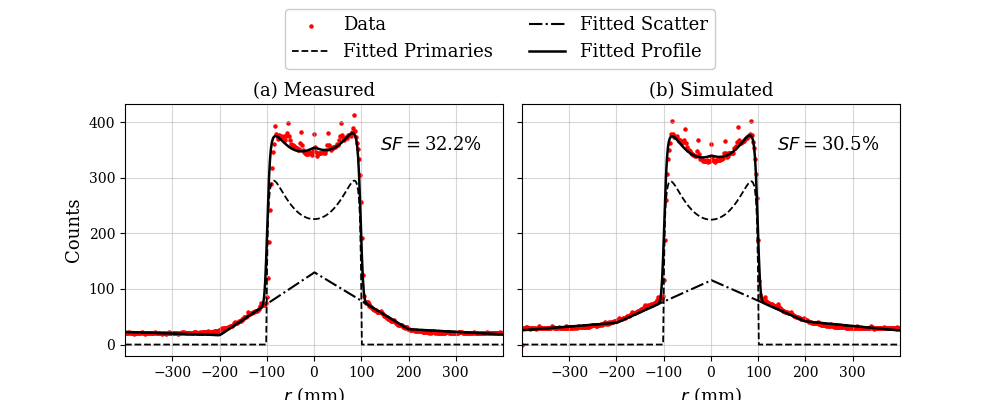

In [7]:
perform_SF_cal(scan_sino, simu_sino)

Now we can compare the two in the image-space

<IPython.core.display.Javascript object>


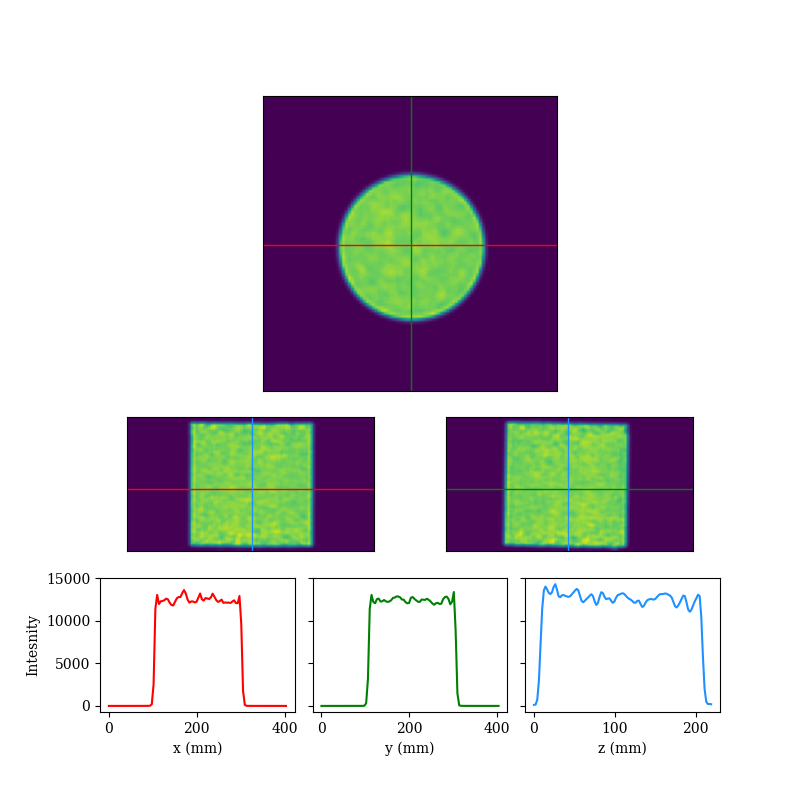

In [8]:
# Load the measured data
image_fn = '../patients/uniform_meas/pet_image_000_000.v'
pet_scan = np.fromfile(image_fn, dtype=np.float32)
# Order: z, x, y
pet_scan = pet_scan.reshape((109,200,200))
# Remove some of the empty space
pet_scan = pet_scan[:,50:-50,50:-50]

plot_img(pet_scan, vmin=np.min(pet_scan), vmax=np.max(pet_scan), 
          slice_indx=[50,50,50], spacing=np.array([2.027, 4.07283, 4.07283]),
         draw_lines=True)

<IPython.core.display.Javascript object>


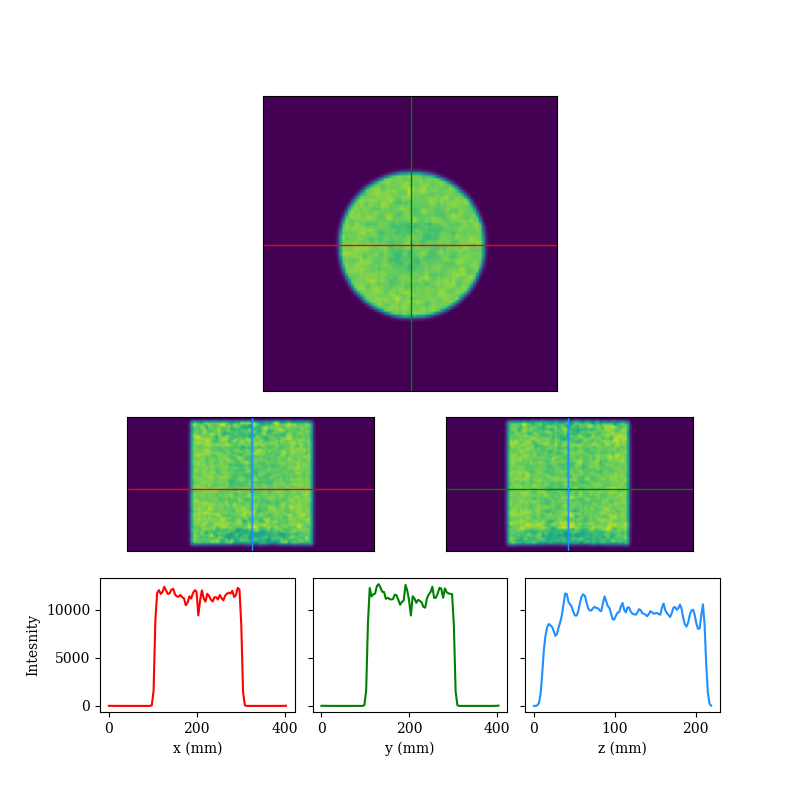

In [9]:
# Load the simulated image
image_fn = '../patients/uniform_simu/pet_image_000_000.v'
pet_simu = np.fromfile(image_fn, dtype=np.float32)
# Order: z, x, y
pet_simu = pet_simu.reshape((109,200,200))
# Remove some of the empty space
pet_simu = pet_simu[:,50:-50,50:-50]

plot_img(pet_simu, vmin=np.min(pet_simu), vmax=np.max(pet_simu), 
          slice_indx=[50,50,50], 
         spacing=np.array([2.027, 4.07283, 4.07283]), draw_lines=True)

Uniformity measurements

1. Draw 5 circular ROIs with a 30-mm diameter.
- 1 at the center of the image.
- 1 at each of the four cardinal locations (12, 3, 6, and 9 o’clock) 10 mm from the edge of the phantom.

2. Project the 5 circular ROIs to the remaining slices in the uniform region (excluding the noisier first and last slices).

3. For each slice (i) and 5 transverse locations (j), obtain the mean activity concentration ($\overline{ROI_{i,j}}$).

4. Calculate uniformity within a slice (IUi) for all slices and axial uniformity between slices ($IU_{axial}$) for each of the 5 ROI locations.

The integral uniformity within slice $i = N$ is calculated using:

\begin{equation}
IU_{I,N} = \frac{\overline{ROI_{N,max}} - \overline{ROI_{N,min}}}{\overline{ROI_{N,max}} + \overline{ROI_{N,min}}}
\end{equation}

where and are the maximum and minimum of the five values measured in slice $N$, respectively.

The integral axial uniformity for a single transverse location is calculated using:

\begin{equation}
IU_{Axial,M} = \frac{\overline{ROI_{max,M}} - \overline{ROI_{min,M}}}{\overline{ROI_{max,M}} + \overline{ROI_{min,M}}}
\end{equation}

where and are the maximum and minimum of the values measured in all slices at transverse location M, respectively. 

Simulation within slice mean and std: 0.0290, 0.0107
Measured within slice mean and std: 0.0145, 0.0045
Simulation within ROI mean and std: 0.0402, 0.0153
Measured within ROI mean and std: 0.0238, 0.0055


<IPython.core.display.Javascript object>


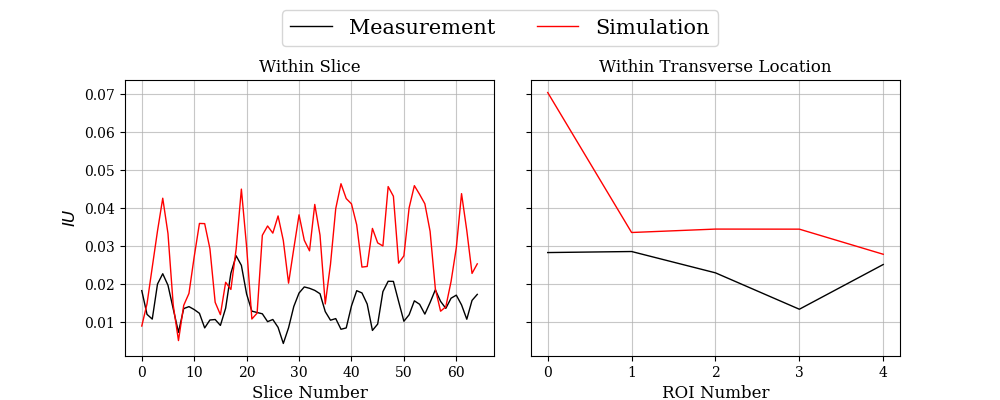

In [10]:
plot_uniformity(pet_simu, pet_scan)